In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, Merge,BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from nltk.stem.porter import PorterStemmer

In [0]:
stemmer = PorterStemmer()



# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = 3873
max_daily_length=200

In [31]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving word_embedding_matrix.csv to word_embedding_matrix (1).csv
User uploaded file "word_embedding_matrix.csv" with length 23375870 bytes


In [0]:
import pandas as pd
import io
word_embedding_matrix= pd.read_csv(io.StringIO(uploaded['word_embedding_matrix.csv'].decode('utf-8')))

In [33]:
print(word_embedding_matrix)

             0         1         2         3         4         5         6  \
0    -0.111920 -0.123580 -0.133040  0.229700  0.382090 -0.392810 -0.474310   
1    -0.034824  0.018151  0.614520 -0.325730  0.098664  0.068916 -0.190860   
2    -0.146800  0.237930  0.340450  0.156800  0.540400 -0.373380 -0.028184   
3    -0.145230  0.778690  0.493820 -0.349520  0.427330  0.404690 -0.555630   
4     0.071062  0.848090  1.415800 -0.328460  0.443230 -0.067387 -0.227620   
5     0.100640 -0.176980  0.189390  0.398780  0.416290 -0.041217  0.495000   
6    -0.388190  0.456810  0.419410  0.307420  0.588540  0.115760 -0.040097   
7    -0.350250  0.102640  0.347510 -0.108940 -0.059054  0.144930  0.936800   
8    -0.478600 -0.052255  0.505240  0.316580  0.220740  0.018776 -0.009640   
9    -0.218110 -0.326090  0.489990  0.415180  0.614790 -0.151960 -0.125020   
10   -0.321890 -0.050835 -0.299460 -0.398530  0.121740  0.154430 -0.065255   
11    0.261510 -0.273070 -0.187360 -0.047141  0.155560  0.315310

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving x_train.csv to x_train.csv
User uploaded file "x_train.csv" with length 1870836 bytes


In [0]:
import pandas as pd
import io
x_train = pd.read_csv(io.StringIO(uploaded['x_train.csv'].decode('utf-8')))

In [26]:
print(x_train)

         0     1     2     3     4     5     6     7     8     9  ...    190  \
0       71     1    97    11  1404   479  1348     6    71     1  ...   3872   
1     3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
2      441   192   655   656    72     1   425  3872  3872  3872  ...   3872   
3      562  2875   183  2874     1   425  2568    71     1  1669  ...   3872   
4     3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
5      322  3871   954  1255   193  2809    72  1264  2317  3872  ...   3872   
6      426     1  1892  3871   429    71  2886  1361    97    11  ...   3872   
7     3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
8       71  1327  1040    62  1005     1  1483  1484   296  3872  ...   3872   
9        3  1095     1   437  2404   930   785     1   153     2  ...   3872   
10    3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
11       1     3   339   999   147   296

In [14]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving x_test.csv to x_test.csv
User uploaded file "x_test.csv" with length 330655 bytes


In [0]:
import pandas as pd
import io
x_test = pd.read_csv(io.StringIO(uploaded['x_test.csv'].decode('utf-8')))

In [22]:
print(x_test)

        0     1     2     3     4     5     6     7     8     9  ...    190  \
0     951   719    71  1424  1247     1   426  1540  1541  3872  ...   3872   
1      71     1    97    11  1661  1362   753   390   111    34  ...   3872   
2    3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
3      71     1    97    11  2620   115   116   190  1301    19  ...   3872   
4    3871  1184   118     1     3    71   236   880  3871  3872  ...   3872   
5      71     1  1892  2854  2855  3872  3872  3872  3872  3872  ...   3872   
6     912   429  1523  2191  2107     1     1    16    19    41  ...   3872   
7    3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
8    3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
9    1297  1298  1299   287    72     3   345    88   588  1300  ...   3872   
10   3872  3872  3872  3872  3872  3872  3872  3872  3872  3872  ...   3872   
11    543  1244  2270     6  3399  1326   196   197 

In [23]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving y_test.csv to y_test (1).csv
User uploaded file "y_test.csv" with length 6335 bytes


In [0]:
import pandas as pd
import io
y_test = pd.read_csv(io.StringIO(uploaded['y_test.csv'].decode('utf-8')))

In [25]:
print(y_test)

            0
0    0.592841
1    0.534509
2    0.535282
3    0.479269
4    0.584857
5    0.583827
6    0.610868
7    0.595416
8    0.539016
9    0.467808
10   0.483389
11   0.599794
12   0.590265
13   0.569663
14   0.702292
15   0.534896
16   0.604430
17   0.599150
18   0.565861
19   0.559104
20   0.608293
21   0.484934
22   0.639196
23   0.493562
24   0.599279
25   0.661087
26   0.587561
27   0.511718
28   0.481329
29   0.408705
..        ...
305  0.550028
306  0.534896
307  0.507855
308  0.424157
309  0.516868
310  0.596704
311  0.604430
312  0.572238
313  0.604558
314  0.548287
315  0.676024
316  0.560587
317  0.519444
318  0.540113
319  0.336338
320  0.706928
321  0.573268
322  0.635333
323  0.654777
324  0.582153
325  0.560649
326  0.541334
327  0.609426
328  0.720577
329  0.581252
330  0.588401
331  0.644795
332  0.690446
333  0.511718
334  0.592712

[335 rows x 1 columns]


In [27]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving y_train.csv to y_train.csv
User uploaded file "y_train.csv" with length 37701 bytes


In [0]:
import pandas as pd
import io
y_train= pd.read_csv(io.StringIO(uploaded['y_train.csv'].decode('utf-8')))

In [29]:
print(y_train)

             0
0     0.584986
1     0.547515
2     0.677826
3     0.668813
4     0.608293
5     0.552923
6     0.576359
7     0.585115
8     0.578676
9     0.549060
10    0.572238
11    0.565800
12    0.576101
13    0.699717
14    0.572047
15    0.605717
16    0.537214
17    0.512748
18    0.637842
19    0.576101
20    0.603142
21    0.583827
22    0.516353
23    0.514293
24    0.466392
25    0.539016
26    0.619882
27    0.612928
28    0.652331
29    0.596704
...        ...
1864  0.599665
1865  0.561102
1866  0.582859
1867  0.480814
1868  0.610868
1869  0.531290
1870  0.544425
1871  0.610095
1872  0.465362
1873  0.505279
1874  0.538759
1875  0.592841
1876  0.650013
1877  0.577517
1878  0.623101
1879  0.580288
1880  0.470512
1881  0.563224
1882  0.607005
1883  0.631471
1884  0.608293
1885  0.571919
1886  0.612156
1887  0.550348
1888  0.479526
1889  0.596704
1890  0.528844
1891  0.581962
1892  0.592841
1893  0.643574

[1894 rows x 1 columns]


In [0]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = False
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2



In [0]:
def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    ####

    model2 = Sequential()
    
    model2.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model2.add(Dropout(dropout))
    
    
    model2.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length2, 
                             padding = 'same',
                             activation = 'relu'))
    model2.add(Dropout(dropout))
    
    if deeper == True:
        model2.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length2, 
                                 padding = 'same',
                                 activation = 'relu'))
        model2.add(Dropout(dropout))
    
    model2.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))
    
    ####

    model = Sequential()

    model.add(Merge([model1, model2], mode='concat'))
    
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    
    if deeper == True:
        model.add(Dense(hidden_dims//2, kernel_initializer=weights))
        model.add(Dropout(dropout))

    model.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipnorm=1.0))
    return model


In [38]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving question_pairs_weights_deeper=True_wider=False_lr=0.001_dropout=0.5.h5 to question_pairs_weights_deeper=True_wider=False_lr=0.001_dropout=0.5.h5
User uploaded file "question_pairs_weights_deeper=True_wider=False_lr=0.001_dropout=0.5.h5" with length 30728920 bytes


In [39]:
ls


datalab/
question_pairs_weights_deeper=True_wider=False_lr=0.001_dropout=0.5.h5
word_embedding_matrix (1).csv
word_embedding_matrix.csv
x_test.csv
x_train.csv
y_test (1).csv
y_test.csv
y_train.csv


In [40]:
# Make predictions with the best weights
deeper=True
wider=False
dropout=0.5
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

model.load_weights('question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)


# In[313]:

# Compare testing loss to training and validating loss
print("mse "+str(mse(y_test, predictions)))


max_price=82.7999880000001
min_price=-111.34997599999997
# In[314]:

rk=y_test.values


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


335/335 [==============================] - 1s 3ms/step
mse 0.007035637306683075


In [41]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving preds.csv to preds.csv
User uploaded file "preds.csv" with length 6354 bytes


In [0]:
import pandas as pd
import io
normpreds= pd.read_csv(io.StringIO(uploaded['preds.csv'].decode('utf-8')))

In [44]:
print(normpreds)

     0.096498150425075
0             0.630098
1             0.560680
2             0.548926
3             0.563868
4             0.668331
5             0.690033
6             0.713262
7             0.670186
8             0.611037
9             0.565045
10            0.541207
11            0.677907
12            0.672143
13            0.675726
14            0.761730
15            0.593461
16            0.660833
17            0.666099
18            0.630691
19            0.617146
20            0.683485
21            0.544417
22            0.729054
23            0.561244
24            0.629402
25            0.662636
26            0.606493
27            0.548154
28            0.506279
29            0.464173
..                 ...
305           0.571849
306           0.580047
307           0.551341
308           0.527330
309           0.444262
310           0.522614
311           0.576977
312           0.583607
313           0.590628
314           0.547567
315           0.667988
316        

In [0]:
unnorm_preds=normpreds.values


def unnormalize(price):
    price = price*(max_price-min_price)+min_price
    return(price)



In [0]:
unnorm_predictions = []
for pred in unnorm_preds:
    unnorm_predictions.append(unnormalize(pred))
  

unnorm_y_test = []
for y in rk:
    unnorm_y_test.append(unnormalize(y))



In [47]:
# Calculate the median absolute error for the predictions
print("mae "+str(mae(unnorm_y_test, unnorm_predictions)))


mae 6.748559931777692


Summary of actual opening price changes
                 
count  335.000000
mean    -0.677940
std     16.290991
min    -98.849976
25%     -6.250000
50%     -0.349976
75%      7.237488
max     54.099976

Summary of predicted opening price changes
                 
count  335.000000
mean    -1.824461
std     17.026072
min   -101.303387
25%     -8.835338
50%     -1.561763
75%      6.503575
max     51.574767


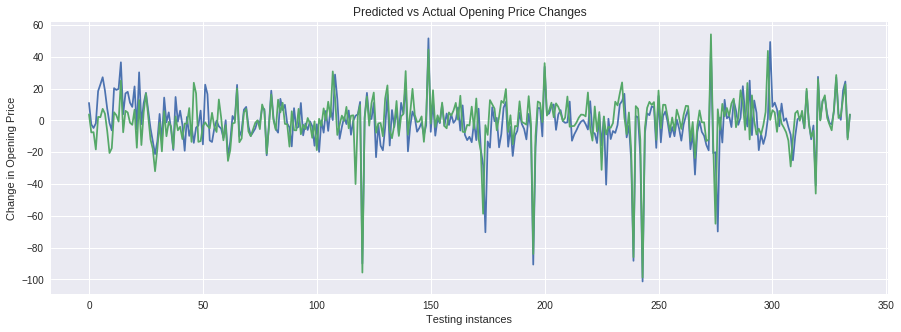

In [49]:
# In[362]:

print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

plt.figure(figsize=(15,5))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted vs Actual Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()